# NEU 502A
## Problem Set #1: Models of Early Visual System

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.io import loadmat
sns.set_style('white')
sns.set_context('notebook', font_scale=1.5)
%matplotlib inline

### 1. Principal Component Analysis of Natural Scenes
In lecture, various attempts to formulate a theory about V1’s functionality were discussed. It is clear that it is not just edge detection, or Fourier Decomposition, although it does have a mixture of these functionalities. Simple cells are tuned to sine waveforms, yet broadly tuned to different spatial frequencies.

The Generative Model View of neural processing has a better approach at trying to explain the computations performed by networks alike the early visual system. In this framework, the brain is proposed to be trying to identify the latent variables that generate a sensory stimulus. The visual stimulus emanates from the latent variables (i.e. natural scenes), is encoded by the sensory machinery and processed by cortical areas (i.e. Visual Cortex). 

The Sparse Coding Model suggests representing multidimensional space as linear combinations of basis vectors, requiring the weights for the linear combinations to be sparse. Olshausen and Field (1996) showed that these basis vectors turn out to resemble V1 receptive fields of mammalian visual cortex, when the model is applied to natural scenes. The method requires over-completion, a larger number of basis vectors than sensory space vectors. On
the other hand, PCA aims to represent the data with the fewest number of basis vectors possible.

Write code to find the principal components that account for the total variance in the information contained in natural images. These can be used to find a reduced descriptive space from which the natural scenes under study can be reconstructed. Load the 10 images found in the “IMAGES_RAW.mat” file.

#### Part A. 
The visual system is composed of units that have increasing receptive field sizes as the information moves up the hierarchy. To approximate those in V1:

Extract 12x12 pixel patches (N = 10000) from the raw images (1000 patches/image). Store them in long vector format producing a 144xN matrix $P$.

In [2]:
from sklearn.feature_extraction.image import extract_patches_2d

## Extract data.
mat = loadmat('IMAGES_RAW.mat')
images = mat['IMAGESr']

## Extract patches.
patches = np.concatenate([extract_patches_2d(images[...,i], [12,12], 1000, 0) 
                          for i in np.arange(images.shape[-1])], axis=0)

## Store in long-list.
patches = patches.reshape(10000, 12*12).T

## Print final form.
patches.shape

(144, 10000)

Implement PCA on the sampled patches. (The 1st component and the patches will be used in Part II.) Remember to zero mean the patches. Show the distribution of eigenvalues (i.e. plot matrix $\Lambda$). 

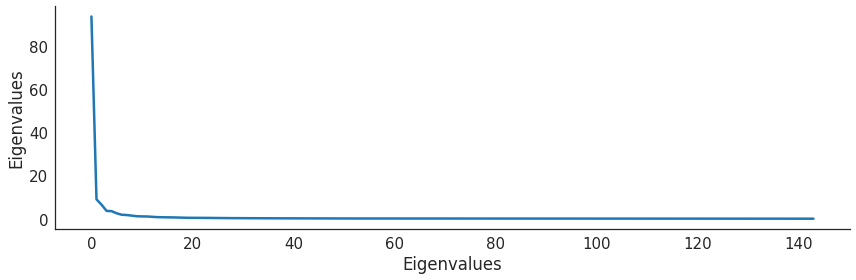

In [3]:
## Compute covariance.
cov = np.cov(patches)

## Perform PCA.
U, s, Vt = np.linalg.svd( cov )

## Plot the eigenvalues.
fig, ax = plt.subplots(1,1,figsize=(12,4))
ax.plot(s, lw=2.5)
ax.set(xlabel='Eigenvalues', ylabel='Eigenvalues')
sns.despine()
plt.tight_layout()

Plot a sensible subset (if not all) of the eigenvectors (eigenimages) with the same dimensionality as a sampled patch (12x12). How does this relate to V1 receptive fields?

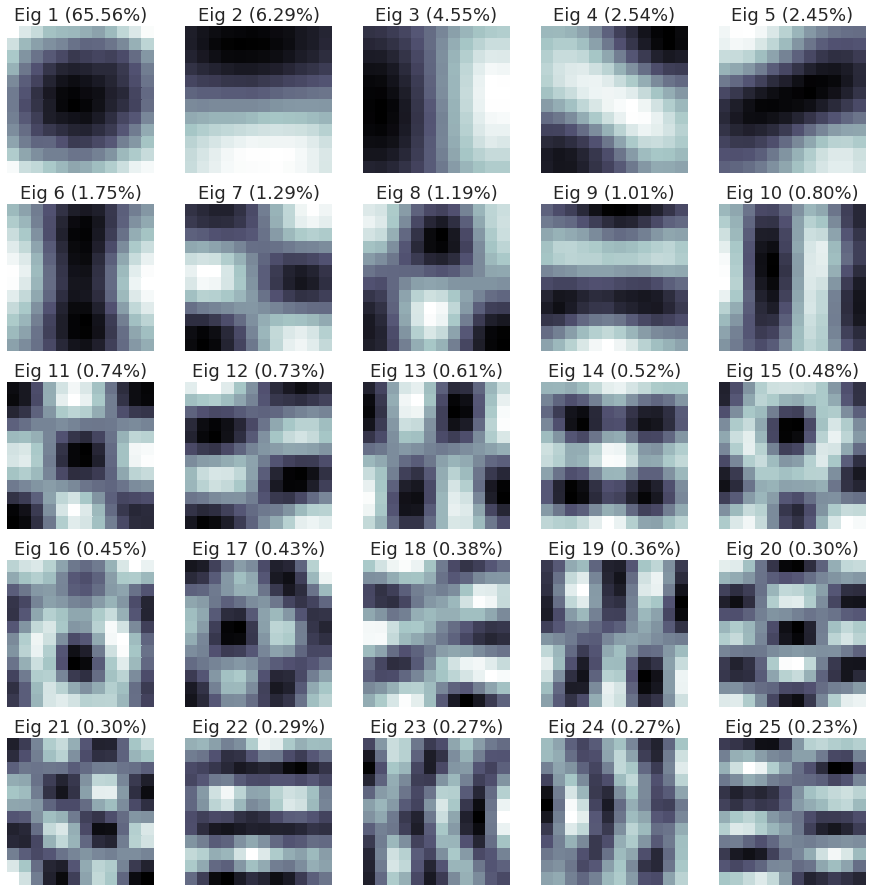

In [4]:
## Normalize eigenvalues.
var_exp = s / s.sum()

## Initialize canvas.
fig, axes = plt.subplots(5,5,figsize=(12.5,12.5))
axes = axes.flatten()

## Plot.
for i, ax in enumerate(axes):
    
    sns.heatmap(U[:,i].reshape(12,12), cmap='bone', square=True, cbar=False, ax=ax)
    ax.set(xticks=[], yticks=[], title='Eig %s (%0.2f%%)' %(i+1, var_exp[i]*100))
    
plt.tight_layout()

**Answer:** The eigenvectors (principal components) resemble Gabor-like filters, which resemble the receptive fields of simple cells in V1. 

#### Part B. 
Each principal component is characterized by its eigenvalue, which is a fraction of the total variance in the sample patches. Use these to implement dimensionality reduction and retain [0.9 0.95 0.99 0.9999] of the variance respectively.

Find the number ($k$) of largest eigenvalues required to account for 0.9(total_variance), and extract the eigenvectors corresponding to these values. Then do so for the other
fractions of the total variance.

In [5]:
## Define thresholds.
thresholds = [0.9, 0.95, 0.99, 0.9999]

## Compute cumulative sum of variance explaiend.
cum_var_exp = np.cumsum(var_exp)

## Find number of largest eigenvalues to account for each threshold.
for threshold in thresholds:
    print('Threshold = %s:\tk = %s' %(threshold, np.argmax(cum_var_exp > threshold)+1))

Threshold = 0.9:	k = 14
Threshold = 0.95:	k = 32
Threshold = 0.99:	k = 89
Threshold = 0.9999:	k = 143


Project the patches unto the reduced space with the selected eigenvectors. Invert the transformation to obtain the matrix $P$, containing the dimension-reduced patches. Do so for each reduced space (i.e. fraction of total variance). Include the case were $k = 1$.

Plot a selection of 25 reconstructed patches for each reduced space, next to the originals. (Remember that patches are in long vector format, must be in 2-D for plot.) Provide a measure of how much information is lost in each case (MSE).

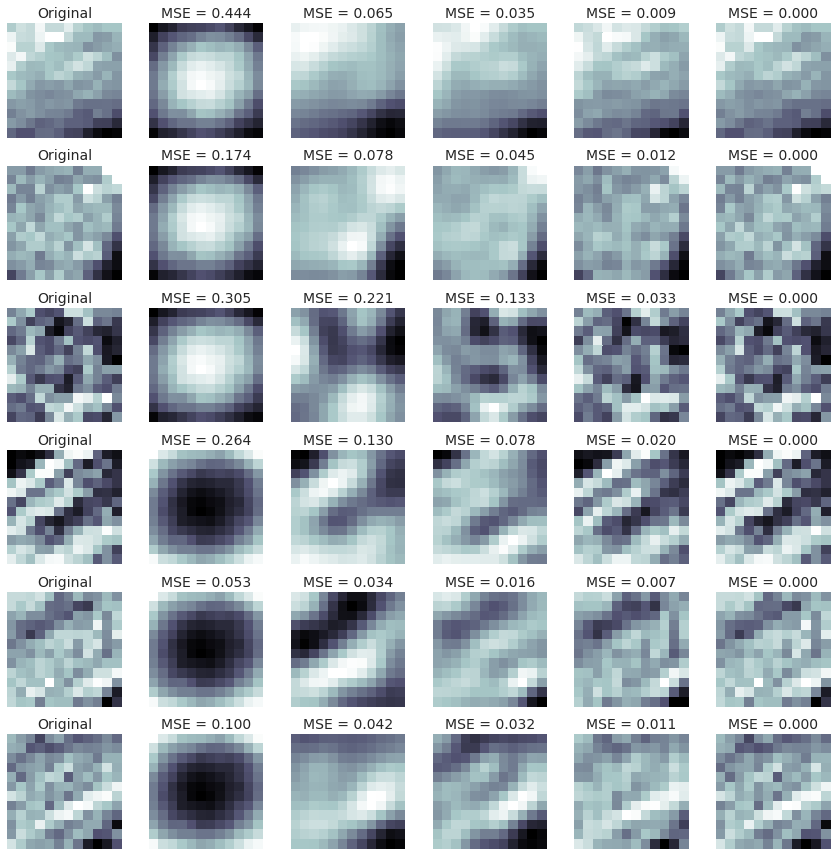

In [6]:
## Define number of components to include.
k = [1, 14, 32, 89, 143]

## Iteratively construct projection matrices.
proj_mats = []
for i in k:
    
    A = U[:,:i] @ U[:,:i].T
    proj_mats.append(A)
    
proj_mats = np.array(proj_mats)

## Append identity matrix for convenience.
proj_mats = np.concatenate([np.identity(144).reshape(1,144,144), proj_mats], axis=0)

## Initialize canvas.
fig, axes = plt.subplots(6, 6, figsize=(12,12))

for i, rx in enumerate(axes):

    for ax, proj in zip(rx, proj_mats):

        ## Project data.
        vec = proj @ patches[:,i]
        
        ## Compute MSE. 
        mse = np.power(patches[:,i] - vec , 2).mean()
        if not mse: title = 'Original'
        else: title = 'MSE = %0.3f' %mse
        
        ## Plot.
        sns.heatmap(vec.reshape(12,12), cmap='bone', square=True, cbar=False, ax=ax)
        ax.set(xticks=[], yticks=[])
        ax.set_title(title, fontsize=14)
    
plt.tight_layout()

### 2. Hebbian Learning
Here the original quote from Hebb:
> "Let us assume that the persistence or repetition of a reverberatory activity (or "trace") tends to induce lasting cellular changes that add to its stability... When an axon of cell A is near enough to excite a cell B and repeatedly or persistently takes part in firing it, some growth process or metabolic change takes place in one or both cells such that A's efficiency, as one of the cells firing B, is increased."

It seems Hebb was referring in his own words to Spike-Timing-Dependent-Plasticity, where the lags between pre- and post-synaptic neurons are responsible for LTP or LTD, depending on which fires first. The simplest learning rule following this description of plasticity takes the following form:

$$ \tau_w \frac{dw}{dt} = vu $$

where $u$ is the input vector containing the activities (i.e. firing rate) of the presynaptic elements. This basic rule includes a single postsynaptic element denoted by $v$. The weight vector is denoted by $w$, representing the synapses between pre-and postsynaptic neurons. The parameter $\tau_w$ controls the rate at which weights between presynaptic and postsynaptic 
elements change (i.e. time required for a fractional change in the weights). The output of the
postsynaptic element $v$ is given by:

$$ v = \vec{w} \cdot \vec{u} = \sum w_i u_i $$

#### Part A. 
Batch-train a feedforward Hebbian neural network with one output element connected to enough input elements to be able to process one patch from Part I at a time. The rule described by Eq. 1 has its limitations, such as instability and lack of competition between synapses. The instability comes from unbounded growth of the weight vector. To deal with this limitation, implement a modified version of Hebb's rule called **Oja Rule**:

$$ \tau_w \frac{dw}{dt} =  v\vec{u} - \alpha v^2\vec{w} $$

where $\alpha$ is a positive constant controlling the pull from the multiplicative normalization term $v^2w$. This term limits the growth of the weight vector, eliminating one of the limitations of the basic rule.

Train the network with the following initial conditions: {$\alpha = 10$, $\tau_w = 200$, iterations $\geq 1000$ batches, 500 inputs/batch, $\left| w_{ij} \right| \leq 0.001$} The input $u$ is a single patch from Part I in long vector format. Use the same patches extracted from the file in Part I.

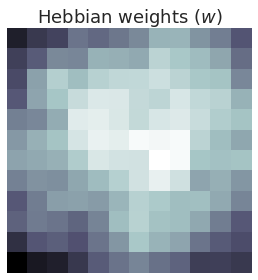

In [7]:
np.random.seed(47404)

## Define parameters.
n_pixels, n_stimuli = patches.shape
n_batches = 1000
n_inputs = 500
tau = 200

## Preallocate space.
W = np.zeros((n_batches, n_pixels))

## Initialize parameters.
w = np.random.choice([-1,1], n_pixels, replace=True) * 1e-3
alpha = 10

## Main loop (batches).
for i in np.arange(n_batches):
    
    ## Select inputs.
    ix = np.random.choice(np.arange(n_stimuli), n_inputs, replace=False)
    
    ## Initialize weight update.
    dw = np.zeros_like(w)
    
    ## Iterate over inputs.
    for j in ix:
        
        ## Define input vector.
        u = patches[:,j]
        
        ## Compute output.
        v = u @ w
        
        ## Compute weight update.
        dw += (u * v - alpha * v**2 * w) / tau
        
    ## Update weights.
    w += dw / n_inputs
    W[i] = w
    
## Plot final weights.
fig, ax = plt.subplots(1,1,figsize=(4,4))
sns.heatmap(w.reshape(12,12), cmap='bone', square=True, cbar=False, ax=ax)
ax.set(xticks=[], yticks=[], title='Hebbian weights ($w$)')
plt.tight_layout()

Track the weights, and plot the progression. Show that the length of the weight vector stabilizes when the stimuli are learned. Do this by showing $\left| w \right|^2 \approx \frac{1}{\alpha}$ as $t \rightarrow \infty$. What does this imply about this modified Hebbian rule? How does it predict the dynamics of the weights throughout learning?

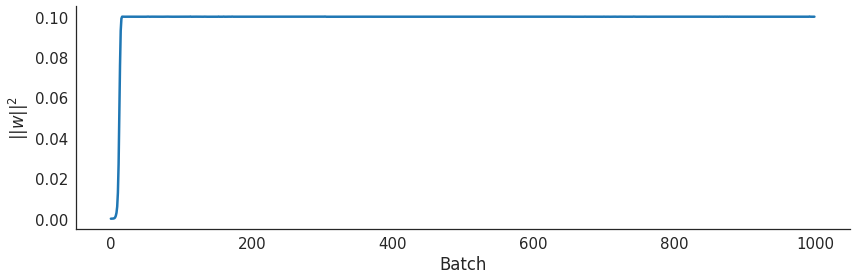

In [8]:
fig, ax = plt.subplots(1,1,figsize=(12,4))
ax.plot(np.linalg.norm(W, axis=-1)**2, lw=2.5)
ax.set(xlabel='Batch', ylabel=r'$||w||^2$')
sns.despine()
plt.tight_layout()

**Answer:** The plot above demonstrates that the modified Hebbian rule is numerically stable. In an unmodified Hebbian network, the weights are unbounded such that they grow towards positively infinity. The Oja rule introduces a "forgetting term", $\alpha v^2 \vec{w}$, that bounds weight change by output activation. The result of this term is that the weights are constrained to be unit vectors of length $\frac{1}{\alpha} = \frac{1}{10} = 0.1$. Consequently, the dynamics of the weights are constrained such that their length asymptotes at $\frac{1}{\alpha}$ when they achieve stability.

---

Use any method you can think of to show that the weight vector of this single output Hebbian network captures the direction of the first principal component of the patches obtained in Part I. Show the evidence.

**Answer:** To measure the similarity of the weight vector and the first principal component, we will use the cosine similarity. By definition:

> Cosine similarity is a measure of similarity between two non-zero vectors of an inner product space that measures the cosine of the angle between them. The cosine of 0 degrees is 1, and it is less than 1 for any other angle in the interval $[0,2\pi)$. It is thus a judgment of orientation and not magnitude: two vectors with the same orientation have a cosine similarity of 1, two vectors at 90 degrees have a similarity of 0, and two vectors diametrically opposed have a similarity of -1, independent of their magnitude. 

Given two vectors, cosine similarity is defined as:

$$ cos(\theta) = \frac{A \cdot B}{\lVert A \rVert \lVert B \rVert} =
    \frac{\sum_{i=1}^{n} A_i B_i}{\sqrt{\sum_{i=1}^n A_i^2}\sqrt{\sum_{i=1}^n B_i^2}}$$

In [9]:
from scipy.spatial.distance import cosine
print('Cosine similarity(u, w) = %0.3f' %(1 - cosine(U[:,0], w)))

Cosine similarity(u, w) = -1.000


What would happen if the network had multiple postsynaptic elements?

**Answer:** As evidenced above, a Hebbian network with one output neuron governed by Oja's rule extracts the first principal component of a data set. If the network has multiple postsynaptic elements, the network can be extended to implement [Generalized Hebbian learning](https://en.wikipedia.org/wiki/Generalized_Hebbian_Algorithm), through which multiple principal components of a dataset can be extracted. Specifically, a Hebbian network with $N$-postsynaptic outputs governed by Oja's rule will extract the top $N$ principal components of the dataset.

---

What modification could be implemented to overcome the limitations of this implementation of Hebbian learning?


**Answer:** A Hebbian network governed by Oja's rule suffers from at least two limitations. First, it can capture only linear relationships among the inputs. This can be plainly observed from the linear relationship between its input and output layers. Insofar that the features of natural stimuli are linear, this is not an issue. There is little reason to assume, however, that the statistics of naturally-occurring images are linear. One way to account for this is to include non-linear transformations between the input and output layers (perhaps bolstered by the inclusion of additional hidden layers, i.e. a deep network). 

Second, by virtue of its equivalence to principle components analysis, Oja rule-goverened Hebbian networks are sensitive only to second-order statistics (i.e. variance). Other statistics of naturally occurring images, however, may contain useful information (i.e. kurtosis). For example, previous research has shown that accounting for higher-order moments in the statistics of image data can be useful for disentangling latent sources and enforcing sparsity in modeling natural images ([Hyvarinen et al., 2000](http://ieeexplore.ieee.org/document/860754/authors)). Similar to above, allowing for non-linear transformations between the input and output layers has been shown to capture higher-order statistics of datasets ([Hyvarinen & Oja, 1998](http://www.ece.ucsb.edu/wcsl/courses/ECE594/594C_F10Madhow/hyvarinen_oja_98.pdf)) and thus might be useful in modeling natural images. 

### 3. Feature-Based Model of Ocular Dominance and Orientation Selectivity
In lecture, it was emphasized that afferents from the retina reach ipsilateral and contralateral LGN, as there is crossover at the optic chiasm. LGN projections reach ipsilateral V1. Visual inputs arriving at both eyes, will reach the same patch of V1. The left side of the visual field will be captured by the right portion of the retina in both eyes and then is sent to the right portion of V1 through right LGN. Inspection of the anatomy of LGN and V1 shows alternating columns of cells receiving left and right afferents respectively. These are referred to as **ocular dominance columns.**

The experiment by Hubel & Wiesel referred to in class, showed that a subset of cells in V1 respond to different orientations of light bars moving across their receptive fields. These neurons are tuned to a preferred orientation. They proposed the Ice Cube Model, where columns of iso-oriented cells span each cortical column of iso-ocular cells. Optical imaging experiments have shown that iso-oriented cells tend to be closer together, giving rise to differentiated "columns" of cortex.

The areas separated by the black lines are the ocular dominance columns, and the grey lines denote iso-orientation contours. Pinwheels are the singularities were all orientations meet. Linear zones are extended regions were iso-orientation contours are parallel. These structures develop as the system receives inputs across the spectrum of these sensory dimensions. Similar mappings can be obtained using **Competitive Feature-Based Models**, adapted to consider ocularity and orientation selectivity. One such model is the **Elastic Net Model.**

Modeling cortical map formation with Hebbian models is highly complex. Evolution of these cortical maps require consideration of retinotopic location, ocular dominance, and orientation preference to be considered simultaneously within the dynamics of the networks and learning rules. Feature based models provide a simpler framework to describe map development. These models characterize neurons and their inputs by feature selectivity, unlike Hebbian models, which use synaptic weights. By the end of development, the receptive field of a cortical cell can be characterized by three values: ocularity, mean topographic location of inputs, and orientation selectivity.

#### Part A.
Write code to simulate cortical column formation by implementing the Elastic Net Model considering five features: 2-dimensional topographic location, orientation preference and strength, and ocularity. Inputs in this type of model are represented by a row vector 

$$ u = [x, \ y, \ o, \ e \cdot cos(\theta), \ e \cdot sin(\theta)]$$

where $(x, y)$ are the topographical location, $o$ is ocularity (left or right as denoted by negative and positive values respectively), $\theta$ is orientation (i.e. angle of bar), and $e$ is orientation strength (i.e. length of bar) of the stimulus. The cortical units are represented by a vector $v$ with the same dimensionality as $u$, denoting their selectivities for each feature dimension. A weight element vector $w$ serves as a normalized force exerted on the selectivity of the cortical units by the input. Changes in the feature vectors of a cortical neuron are given by the update rule:

$$ V_{t+1} = V_t + \alpha w \cdot (u - V_t) + \beta \sum_i^L V_{t,i} - V_t $$

where $L$ describes the neighbors of a unit $v_i$ in the four cardinal directions. Here, the weight vector $w$ is scaled by the difference between the selectivity of the cortical neuron:

$$ w_i = \frac{f \left( \lVert u - v_i \rVert, \sigma ) \right)}{\sum_i f \left( \lVert u - v_i \rVert, \sigma ) \right)} $$

where the function $f$ is defined as:

$$ f \left( | u - v_i |, \sigma ) \right) = \text{exp} \left( \frac{-\lVert u-v_i \rVert^2}{2 \sigma^2} \right)  $$

Note that the weights $w$ are also scaled by a learning rate $\alpha$. The change in the selectivity of a neuron will also be affected by the activity of its closest neighbors, scaled by a pull constant $\beta$. The weight vector $w$ introduces competition among cortical units by normalizing the effect of the input on cortical units and biasing in favor of units aligned closely to its feature values. Specifically, $f$ models the effect of the input on cortical neurons as the distance between the input and the feature selectivity of the neuron, given by the Euclidean distance between the vectors, passed through a Gaussian filter, where $\sigma$ controls the effective range (distance) between an input and the cortical neurons.


Let a patch of visual cortex be defined by an $NxN$ sheet of cells $V$, where $N = 50$ (the larger the $N$ the smoother the map will turn out). Each of these will be defined by a vector,

$$ v_i= \left[ x_i, \ y_i, \ o_i, \ e_i \cdot cos(\theta_i), \ e_i \cdot sin(\theta_i) \right] $$

where the $(x, y)$ positions are defined from the $NxN$ sheet; $o_i$ are initialized at 0; $e_i$ are initialized at $e_i = 0.01 \cdot e_{max} = 0.01 \cdot 61.44$; and $\theta_i$ are equally spaced between 0 and $\pi$. Define the patch in long vector form $[N^2, 1]$. Make sure initial values of orientation selectivity are randomly distributed across the 2D cortical sheet.

In [10]:
## Initialize vector.
N = 50
V = np.zeros((N**2,5))

## Store x,y positions.
V[:,:2] = np.array(np.meshgrid(np.arange(N), np.arange(N))).T.reshape(N**2,2)

## Store orientation info.
np.random.seed(47404)
theta = np.random.choice(np.linspace(0,np.pi,N**2), N**2, replace=False)
V[:,-2] = 0.01 * 61.44 * np.cos(theta)
V[:,-1] = 0.01 * 61.44 * np.sin(theta)

Generate 2 million stimuli with uniform probability for all sensory features:

$$ U = \left[ x, \ y, \ o, \ e \cdot cos(\theta), \ e \cdot sin(\theta) \right] $$

where $x, y \in [0, N], o \in [-o_{max}, o_{min}], e \in [0, e_{max}], \theta \in [0, \pi].$

In [11]:
np.random.seed(47404)

## Simulate data.
n = int(2e6)
U = np.array([np.random.uniform(0,N,n), 
              np.random.uniform(0,N,n),
              np.random.uniform(-46.08,46.08,n),
              np.random.uniform(0,61.44,n) * np.cos(np.random.uniform(0,np.pi,n)),
              np.random.uniform(0,61.44,n) * np.sin(np.random.uniform(0,np.pi,n))]).T

Find the locations of the neighbors for all the cortical units and store them in a matrix $L$. Use circular boundary conditions to avoid edge effects.

In [12]:
from scipy.sparse import csr_matrix

## Preallocate space.
L = np.zeros((N**2, N**2), dtype=int)

## Initialize adjacency matrix.
loc = V[:,:2].copy()
for i in np.arange(N**2):
    L[i] += (np.linalg.norm(loc - loc[i], axis=1) == 1).astype(int)
    
## Account for circular boundaries.
loc = np.where(loc == N-1, -1, loc)
for i in np.arange(N**2):
    L[i] += (np.linalg.norm(loc - loc[i], axis=1) == 1).astype(int)

## Convert into sparse matrix.
Ls = csr_matrix(L.astype(bool).astype(int))

Iterate the model over all stimuli.

In [13]:
import os
from tqdm import tqdm

## Check if file exists.
if os.path.isfile('V1.npy'):
    
    V = np.load('V1.npy')

else:
    
    ## Define parameters.
    alpha = 0.4
    beta = 1e-4
    sigma = 2.771
    f = lambda V, u, sigma: np.exp( -(np.linalg.norm(u - V, axis=1) ** 2) / (2 * sigma ** 2) )
    
    for i in tqdm(np.arange(2e6, dtype=int)):

        ## Compute weight vector.
        w = f(V, U[i], sigma)
        w /= w.sum()

        ## Compute first term.
        m1 = alpha * ((U[i] - V).T * w).T

        ## Compute second term (beta & sigma).
        m2 = beta * (Ls @ V - V * 4)

        ## Update units.
        V += m1 + m2

    ## Save file.
    np.save('V1', V)

Plot the resulting cortical map, overlaying contours of iso-ocularity and contour lines of iso-orientation. Threshold ocularity to make it seem all neurons are monocular (different thresholds can provide different distributions of monocular and binocular neurons). The contour lines for iso-orientation should represent a shift of $15^o$. This plot should look similar Figure 2B. (Emphasis on “similar”, as it will not be identical due to differences in some parameters and thresholding for contours... bonus points if you can replicate it!)

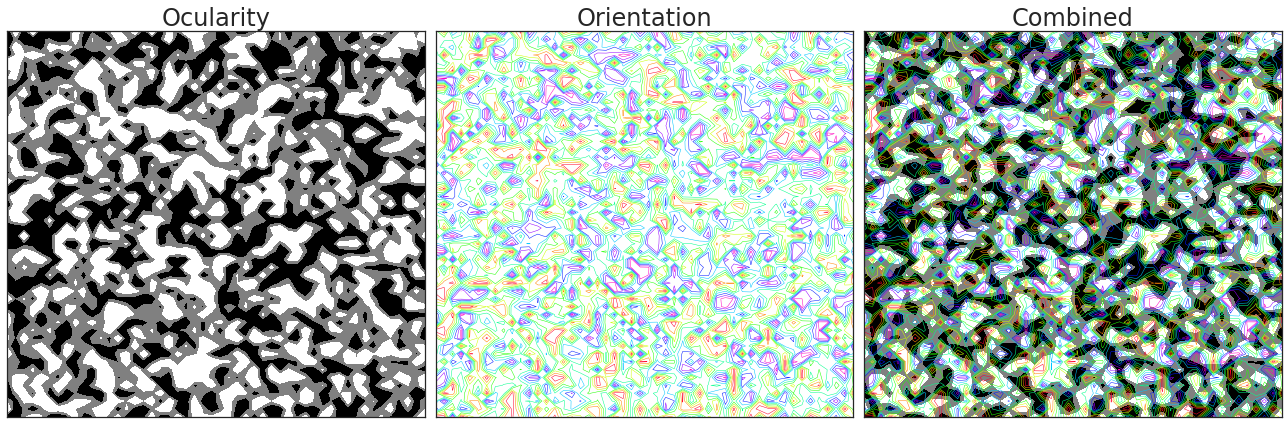

In [14]:
from matplotlib.colors import ListedColormap

## Sort data.
V = V[np.lexsort([V[:,1], V[:,0]])]

## Extract ocularity and orientation.
ocularity = V[:,2].reshape(N,N)
orientation = np.arctan2(V[:,-2], V[:,-1]).reshape(N,N)

## Initialize canvas.
fig, axes = plt.subplots(1,3,figsize=(18,6))

## Plot ocularity alone.
cmap = ListedColormap(['k','grey','w'])
axes[0].contourf(ocularity, cmap=cmap, levels=[-40,-10,10,40])

## Plot orientation alone.
levels = np.linspace(orientation.min(), orientation.max(), 11)
axes[1].contour(orientation, cmap='gist_rainbow', levels=levels, linewidths=0.5)

## Plot together.
axes[2].contourf(ocularity, cmap=cmap, levels=[-40,-10,10,40])
axes[2].contour(orientation, cmap='gist_rainbow', levels=levels, linewidths=0.5)

## Add info.
for ax, title in zip(axes,['Ocularity','Orientation','Combined']): 
    ax.set(xticks=[], yticks=[])
    ax.set_title(title, fontsize=24)

plt.tight_layout()

#### Part B
**Eye depravation:** Run a new model with the same parameters and initial conditions, except for the distribution of ocularity values for the stimuli. The task is to simulate deprivation of the right eye. To do this let $ o \in [−o_{max}, \gamma \cdot o_{max}] $, where $\gamma = \frac{1}{2}$. This increases the frequency of negative values (left eye) of $o$, and limits the strength of positive values (right eye). Show the results in a similar fashion to part A. How can you relate the results to what is known about eye deprivation?

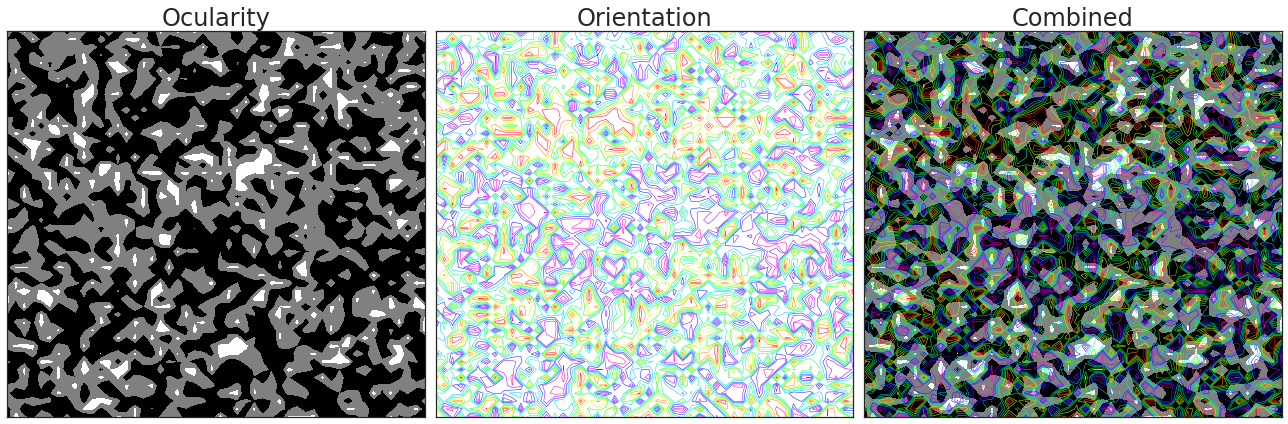

In [15]:
np.random.seed(47404)

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Prepare data.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Initialize vector.
N = 50
V = np.zeros((N**2,5))

## Store x,y positions.
V[:,:2] = np.array(np.meshgrid(np.arange(N), np.arange(N))).T.reshape(N**2,2)

## Store orientation info.
theta = np.random.choice(np.linspace(0,np.pi,N**2), N**2, replace=False)
V[:,-2] = 0.01 * 61.44 * np.cos(theta)
V[:,-1] = 0.01 * 61.44 * np.sin(theta)

## Simulate data.
n = int(2e6)
U = np.array([np.random.uniform(0,N,n), 
              np.random.uniform(0,N,n),
              np.random.uniform(-46.08,46.08 * 0.5,n),
              np.random.uniform(0,61.44,n) * np.cos(np.random.uniform(0,np.pi,n)),
              np.random.uniform(0,61.44,n) * np.sin(np.random.uniform(0,np.pi,n))]).T

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Train network.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Check if file exists.
if os.path.isfile('V2.npy'):
    
    V = np.load('V2.npy')

else:
    
    ## Define parameters.
    alpha = 0.4
    beta = 1e-4
    sigma = 2.771
    f = lambda V, u, sigma: np.exp( -(np.linalg.norm(u - V, axis=1) ** 2) / (2 * sigma ** 2) )
    
    for i in tqdm(np.arange(2e6, dtype=int)):

        ## Compute weight vector.
        w = f(V, U[i], sigma)
        w /= w.sum()

        ## Compute first term.
        m1 = alpha * ((U[i] - V).T * w).T

        ## Compute second term (beta & sigma).
        m2 = beta * (Ls @ V - V * 4)

        ## Update units.
        V += m1 + m2

    ## Save file.
    np.save('V2', V)
    
## Sort data.
V = V[np.lexsort([V[:,1], V[:,0]])]

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Plotting.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Extract ocularity and orientation.
ocularity = V[:,2].reshape(N,N)
orientation = np.arctan2(V[:,-2], V[:,-1]).reshape(N,N)

## Initialize canvas.
fig, axes = plt.subplots(1,3,figsize=(18,6))

## Plot ocularity alone.
cmap = ListedColormap(['k','grey','w'])
axes[0].contourf(ocularity, cmap=cmap, levels=[-40,-10,10,40])

## Plot orientation alone.
levels = np.linspace(orientation.min(), orientation.max(), 11)
axes[1].contour(orientation, cmap='gist_rainbow', levels=levels, linewidths=0.5)

## Plot together.
axes[2].contourf(ocularity, cmap=cmap, levels=[-40,-10,10,40])
axes[2].contour(orientation, cmap='gist_rainbow', levels=levels, linewidths=0.5)

## Add info.
for ax, title in zip(axes,['Ocularity','Orientation','Combined']): 
    ax.set(xticks=[], yticks=[])
    ax.set_title(title, fontsize=24)

plt.tight_layout()

Compare ocularity between the two models. 

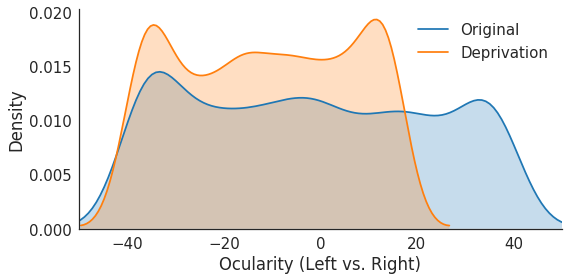

In [16]:
## Load data.
V1 = np.load('V1.npy')
V2 = np.load('V2.npy')

## Initialize canvas.
fig, ax = plt.subplots(1,1,figsize=(8,4))

## Plot.
sns.kdeplot(V1[:,2], shade=True, cut=2, label='Original', ax=ax)
sns.kdeplot(V2[:,2], shade=True, cut=2, label='Deprivation', ax=ax)
ax.set(xlim=(-50,50), xlabel='Ocularity (Left vs. Right)', ylabel='Density')

sns.despine()
plt.tight_layout()

As can be observed above, in the case of monocular deprivation, fewer neurons represent inputs from the right eye (positive values, white filled contour) and more neurons represent inputs from the left eye (negative values, black filled contour). This resemble the anatomic changes observed in monocular deprivation experiments. Specifically, the ocular dominance columns corresponding to the unperturbed eye dominate and are overrepresented, while columns corresponding to the deprived eye are sparse and underrepresented. 